In [1]:
# ANÁLISIS EXPLORATORIO DE DATOS - NECROPSIAS GUATEMALA (INE)
# Universidad del Valle de Guatemala - CC3074 Minería de Datos

## 1. CONFIGURACIÓN INICIAL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
import warnings
import os
import re
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import glob

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

os.makedirs('resultados', exist_ok=True)
os.makedirs('graficos', exist_ok=True)

print(" Librerías cargadas exitosamente")

 Librerías cargadas exitosamente


## 2. CARGA Y UNIÓN DE DATOS

In [37]:
# Usar directorio actual
ruta_datos = "."

archivos = glob.glob(os.path.join(ruta_datos, "necropsias*.sav"))
print(f"\n Archivos encontrados: {len(archivos)}")
for archivo in sorted(archivos):
    print(f"   - {os.path.basename(archivo)}")


 Archivos encontrados: 11
   - necropsias2011.sav
   - necropsias2012.sav
   - necropsias2016.sav
   - necropsias2017.sav
   - necropsias2018.sav
   - necropsias2019.sav
   - necropsias2020.sav
   - necropsias2021.sav
   - necropsias2022.sav
   - necropsias2023.sav
   - necropsias2024.sav


In [39]:
def cargar_necropsia(archivo):
    """Carga un archivo .sav de necropsias y agrega columna de año"""
    nombre_archivo = os.path.basename(archivo)
    anio = re.search(r'(\d{4})', nombre_archivo)
    
    if anio:
        anio = int(anio.group(1))
    else:
        print(f"No se pudo extraer el año de: {nombre_archivo}")
        return None
    
    try:
        df, meta = pyreadstat.read_sav(archivo)
        df['anio'] = anio
        print(f"{nombre_archivo}: {len(df)} registros")
        return df
    except Exception as e:
        print(f"Error al cargar {nombre_archivo}: {str(e)}")
        return None

lista_dataframes = []
for archivo in sorted(archivos):
    df = cargar_necropsia(archivo)
    if df is not None:
        lista_dataframes.append(df)

print("\n Uniendo todos los datasets...")
necropsias = pd.concat(lista_dataframes, ignore_index=True, sort=False)

print(f" DATOS CARGADOS EXITOSAMENTE")
print(f"\n Total de registros: {len(necropsias):,}")
print(f" Total de variables: {len(necropsias.columns)}")
print(f" Años disponibles: {sorted(necropsias['anio'].unique())}")

necropsias2011.sav: 13137 registros
necropsias2012.sav: 12753 registros
necropsias2016.sav: 12179 registros
necropsias2017.sav: 11848 registros
necropsias2018.sav: 11512 registros
necropsias2019.sav: 11351 registros
necropsias2020.sav: 8819 registros
necropsias2021.sav: 10281 registros
necropsias2022.sav: 10729 registros
necropsias2023.sav: 11038 registros
necropsias2024.sav: 2598 registros

 Uniendo todos los datasets...
 DATOS CARGADOS EXITOSAMENTE

 Total de registros: 116,245
 Total de variables: 31
 Años disponibles: [2011, 2012, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


## 3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS

Los archivos de diferentes años tienen nombres de variables ligeramente distintos.
Consolidamos las variables duplicadas para tener un dataset uniforme.

In [40]:
print("3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS")

# 3.1 Consolidar variables de EDAD
print("\n Consolidando variable EDAD...")
necropsias['edad'] = necropsias['edad_per'].fillna(necropsias['edad_person'])
# Limpiar valores inválidos (999 = desconocido según INE)
necropsias.loc[necropsias['edad'] >= 999, 'edad'] = np.nan
print(f"    edad: {necropsias['edad'].notna().sum():,} valores válidos")

# 3.2 Consolidar variables de SEXO
print("\n Consolidando variable SEXO...")
necropsias['sexo'] = necropsias['sexo_per'].fillna(
    necropsias['sexo_person'].fillna(necropsias['sexo_per_eva'])
)
# Codificar: 1=Hombre, 2=Mujer, 9=No especificado
necropsias.loc[necropsias['sexo'] == 9, 'sexo'] = np.nan
print(f"    sexo: {necropsias['sexo'].notna().sum():,} valores válidos")

# 3.3 Consolidar MES de ocurrencia
print("\n Consolidando variable MES...")
necropsias['mes'] = necropsias['mes_ocu'].fillna(necropsias['mes_ing'])
print(f"    mes: {necropsias['mes'].notna().sum():,} valores válidos")

# 3.4 Consolidar DÍA DE LA SEMANA
print("\n Consolidando variable DÍA DE LA SEMANA...")
necropsias['dia_semana'] = necropsias['diasem_ocu'].fillna(
    necropsias['día_sem_ocu'].fillna(necropsias['dia_sem_ocu'])
)
print(f"    dia_semana: {necropsias['dia_semana'].notna().sum():,} valores válidos")

# 3.5 Consolidar CAUSA DE MUERTE
print("\n Consolidando variable CAUSA DE MUERTE...")
necropsias['causa'] = necropsias['causa_muerte'].fillna(necropsias['eva_mn'])
print(f"    causa: {necropsias['causa'].notna().sum():,} valores válidos")

# 3.6 Consolidar MUNICIPIO
print("\n Consolidando variable MUNICIPIO...")
necropsias['municipio'] = necropsias['mupio_ocu']
print(f"    municipio: {necropsias['municipio'].notna().sum():,} valores válidos")

# 3.7 Consolidar DEPARTAMENTO
necropsias['departamento'] = necropsias['depto_ocu']

# Crear dataset limpio con variables consolidadas
vars_limpias = ['anio', 'mes', 'dia_semana', 'departamento', 'municipio', 
                'edad', 'sexo', 'causa']
df_limpio = necropsias[vars_limpias].copy()

print(f"\n Dataset limpio creado con {len(vars_limpias)} variables consolidadas")
print(f" Registros totales: {len(df_limpio):,}")

# Resumen de valores faltantes después de limpieza
print("\n Valores faltantes después de consolidación:")
for col in vars_limpias:
    faltantes = df_limpio[col].isna().sum()
    pct = faltantes / len(df_limpio) * 100
    print(f"   {col:15s}: {faltantes:,} ({pct:.1f}%)")

3. LIMPIEZA Y CONSOLIDACIÓN DE DATOS

 Consolidando variable EDAD...
    edad: 114,692 valores válidos

 Consolidando variable SEXO...
    sexo: 115,286 valores válidos

 Consolidando variable MES...
    mes: 116,245 valores válidos

 Consolidando variable DÍA DE LA SEMANA...
    dia_semana: 46,890 valores válidos

 Consolidando variable CAUSA DE MUERTE...
    causa: 116,245 valores válidos

 Consolidando variable MUNICIPIO...
    municipio: 78,176 valores válidos

 Dataset limpio creado con 8 variables consolidadas
 Registros totales: 116,245

 Valores faltantes después de consolidación:
   anio           : 0 (0.0%)
   mes            : 0 (0.0%)
   dia_semana     : 69,355 (59.7%)
   departamento   : 0 (0.0%)
   municipio      : 38,069 (32.7%)
   edad           : 1,553 (1.3%)
   sexo           : 959 (0.8%)
   causa          : 0 (0.0%)


## 4. DESCRIPCIÓN DEL DATASET

In [41]:
print("4. DESCRIPCIÓN DEL DATASET")

print(f"\n Dimensiones del dataset limpio:")
print(f"   - Observaciones (filas): {df_limpio.shape[0]:,}")
print(f"   - Variables (columnas): {df_limpio.shape[1]}")

print(f"\n Variables y tipos:")
for col in df_limpio.columns:
    tipo = str(df_limpio[col].dtype)
    no_nulos = df_limpio[col].notna().sum()
    print(f"   {col:15s} | {tipo:10s} | {no_nulos:,} valores")

4. DESCRIPCIÓN DEL DATASET

 Dimensiones del dataset limpio:
   - Observaciones (filas): 116,245
   - Variables (columnas): 8

 Variables y tipos:
   anio            | int64      | 116,245 valores
   mes             | float64    | 116,245 valores
   dia_semana      | float64    | 46,890 valores
   departamento    | float64    | 116,245 valores
   municipio       | float64    | 78,176 valores
   edad            | float64    | 114,692 valores
   sexo            | float64    | 115,286 valores
   causa           | float64    | 116,245 valores


In [42]:
# Estadísticas descriptivas
print("\n Estadísticas descriptivas:")
print(df_limpio.describe())

# Guardar
df_limpio.describe().to_csv('resultados/estadisticas_descriptivas.csv')


 Estadísticas descriptivas:
                anio            mes    dia_semana   departamento  \
count  116245.000000  116245.000000  46890.000000  116245.000000   
mean     2017.731971       6.444380      4.118810       7.750914   
std         3.973489       3.508789      2.088353       7.211122   
min      2011.000000       1.000000      1.000000       1.000000   
25%      2016.000000       3.000000      2.000000       1.000000   
50%      2018.000000       6.000000      4.000000       5.000000   
75%      2021.000000      10.000000      6.000000      14.000000   
max      2024.000000      12.000000      7.000000      99.000000   

          municipio           edad           sexo          causa  
count  78176.000000  114692.000000  115286.000000  116245.000000  
mean     795.524048      35.006766       1.174488      19.291247  
std      719.766829      18.124620       0.379530      13.435863  
min      101.000000       0.000000       1.000000       1.000000  
25%      108.000000    

## 5. ANÁLISIS DE VARIABLES NUMÉRICAS

In [43]:
print("="*80)
print("5. ANÁLISIS DE VARIABLES NUMÉRICAS")
print("="*80)

# 5.1 EDAD - Análisis detallado
print("\n 5.1 Análisis de EDAD")
edad_valida = df_limpio['edad'].dropna()
print(f"   N válido: {len(edad_valida):,}")
print(f"   Media: {edad_valida.mean():.2f} años")
print(f"   Mediana: {edad_valida.median():.2f} años")
print(f"   Desv. Est.: {edad_valida.std():.2f}")
print(f"   Mínimo: {edad_valida.min():.0f}")
print(f"   Máximo: {edad_valida.max():.0f}")
print(f"   Asimetría: {edad_valida.skew():.3f}")
print(f"   Curtosis: {edad_valida.kurtosis():.3f}")

# Prueba de normalidad D'Agostino-Pearson (para muestras grandes)
if len(edad_valida) > 8:
    stat, p_value = normaltest(edad_valida.sample(min(5000, len(edad_valida))))
    print(f"\n   Test D'Agostino-Pearson:")
    print(f"   Estadístico: {stat:.4f}, p-value: {p_value:.6f}")
    print(f"   {' NO sigue distribución normal' if p_value < 0.05 else ' Sigue distribución normal'}")

5. ANÁLISIS DE VARIABLES NUMÉRICAS

 5.1 Análisis de EDAD
   N válido: 114,692
   Media: 35.01 años
   Mediana: 31.00 años
   Desv. Est.: 18.12
   Mínimo: 0
   Máximo: 100
   Asimetría: 0.665
   Curtosis: 0.251

   Test D'Agostino-Pearson:
   Estadístico: 360.1390, p-value: 0.000000
    NO sigue distribución normal


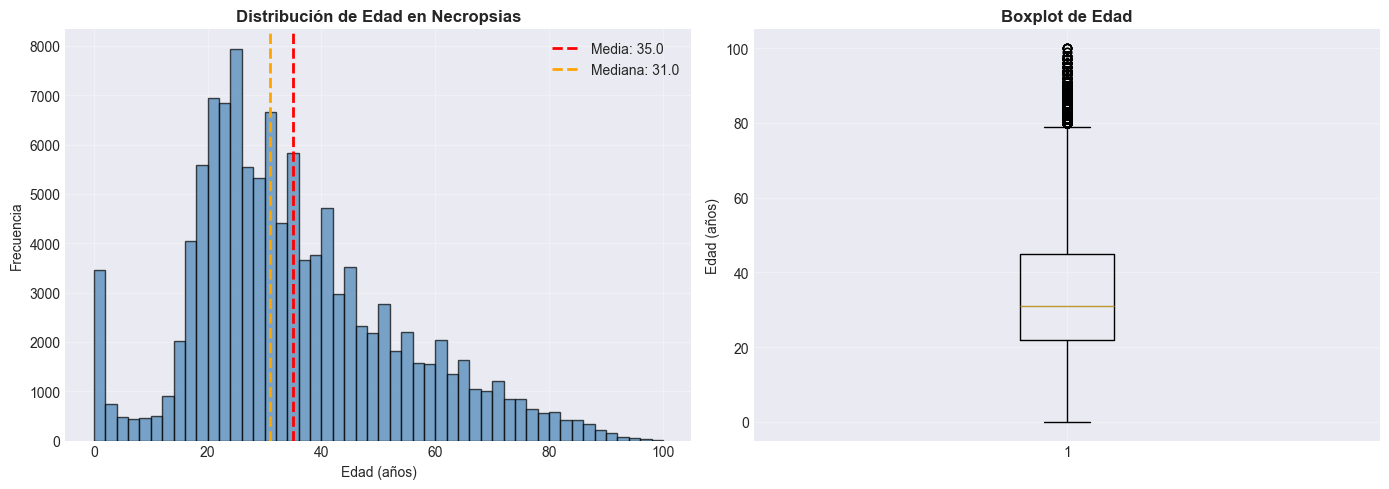

In [44]:
# Histograma de edad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(edad_valida, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(edad_valida.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {edad_valida.mean():.1f}')
axes[0].axvline(edad_valida.median(), color='orange', linestyle='--', linewidth=2, label=f'Mediana: {edad_valida.median():.1f}')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Edad en Necropsias', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(edad_valida, vert=True)
axes[1].set_ylabel('Edad (años)')
axes[1].set_title('Boxplot de Edad', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graficos/edad_distribucion.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. ANÁLISIS DE VARIABLES CATEGÓRICAS

In [45]:
print("="*80)
print("6. ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*80)

# 6.1 SEXO
print("\n 6.1 Distribución por SEXO")
sexo_map = {1: 'Hombre', 2: 'Mujer'}
df_limpio['sexo_nombre'] = df_limpio['sexo'].map(sexo_map)
sexo_freq = df_limpio['sexo_nombre'].value_counts()
sexo_pct = df_limpio['sexo_nombre'].value_counts(normalize=True) * 100

print("\n   Tabla de frecuencias:")
for cat in sexo_freq.index:
    print(f"   {cat:10s}: {sexo_freq[cat]:,} ({sexo_pct[cat]:.1f}%)")

6. ANÁLISIS DE VARIABLES CATEGÓRICAS

 6.1 Distribución por SEXO

   Tabla de frecuencias:
   Hombre    : 95,170 (82.6%)
   Mujer     : 20,116 (17.4%)


In [46]:
# 6.2 DEPARTAMENTO
print("\n 6.2 Distribución por DEPARTAMENTO")

# Diccionario de departamentos de Guatemala
deptos_gt = {
    1: 'Guatemala', 2: 'El Progreso', 3: 'Sacatepéquez', 4: 'Chimaltenango',
    5: 'Escuintla', 6: 'Santa Rosa', 7: 'Sololá', 8: 'Totonicapán',
    9: 'Quetzaltenango', 10: 'Suchitepéquez', 11: 'Retalhuleu', 12: 'San Marcos',
    13: 'Huehuetenango', 14: 'Quiché', 15: 'Baja Verapaz', 16: 'Alta Verapaz',
    17: 'Petén', 18: 'Izabal', 19: 'Zacapa', 20: 'Chiquimula',
    21: 'Jalapa', 22: 'Jutiapa'
}

df_limpio['depto_nombre'] = df_limpio['departamento'].map(deptos_gt)
depto_freq = df_limpio['depto_nombre'].value_counts()
print("\n   Top 10 departamentos:")
for i, (depto, count) in enumerate(depto_freq.head(10).items(), 1):
    pct = count / len(df_limpio) * 100
    print(f"   {i:2d}. {depto:20s}: {count:,} ({pct:.1f}%)")


 6.2 Distribución por DEPARTAMENTO

   Top 10 departamentos:
    1. Guatemala           : 44,009 (37.9%)
    2. Escuintla           : 11,272 (9.7%)
    3. Quetzaltenango      : 5,621 (4.8%)
    4. Petén               : 5,291 (4.6%)
    5. Chiquimula          : 4,703 (4.0%)
    6. Izabal              : 4,610 (4.0%)
    7. Santa Rosa          : 4,403 (3.8%)
    8. Alta Verapaz        : 3,756 (3.2%)
    9. Jutiapa             : 3,614 (3.1%)
   10. Suchitepéquez       : 3,409 (2.9%)


In [47]:
# 6.3 CAUSA DE MUERTE
print("\n 6.3 Distribución por CAUSA DE MUERTE")

# Códigos simplificados de causa (según clasificación INE)
causas_map = {
    1: 'Arma de fuego', 2: 'Arma blanca', 3: 'Estrangulación', 
    4: 'Trauma contundente', 5: 'Caída', 6: 'Ahogamiento',
    20: 'Accidente tránsito', 37: 'Causa natural', 43: 'Otra/Desconocida'
}

causa_freq = df_limpio['causa'].value_counts().head(10)
print("\n   Top 10 causas de muerte:")
for i, (causa, count) in enumerate(causa_freq.items(), 1):
    nombre = causas_map.get(int(causa), f'Código {int(causa)}')
    pct = count / df_limpio['causa'].notna().sum() * 100
    print(f"   {i:2d}. {nombre:25s}: {count:,} ({pct:.1f}%)")


 6.3 Distribución por CAUSA DE MUERTE

   Top 10 causas de muerte:
    1. Causa natural            : 29,741 (25.6%)
    2. Accidente tránsito       : 26,055 (22.4%)
    3. Arma blanca              : 16,483 (14.2%)
    4. Arma de fuego            : 10,333 (8.9%)
    5. Ahogamiento              : 5,478 (4.7%)
    6. Código 21                : 5,410 (4.7%)
    7. Código 19                : 3,334 (2.9%)
    8. Código 27                : 2,724 (2.3%)
    9. Código 22                : 2,258 (1.9%)
   10. Estrangulación           : 2,231 (1.9%)


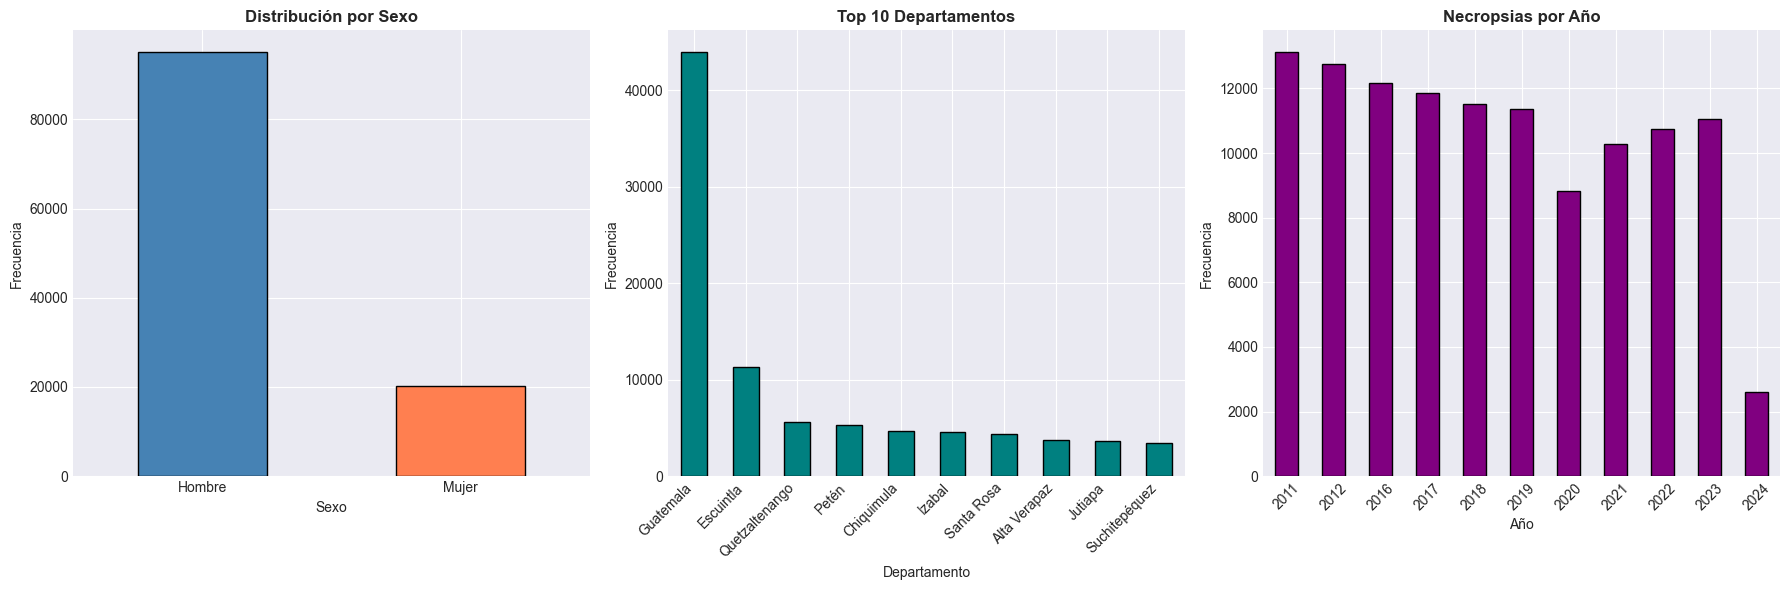

In [48]:
# Gráfico de barras - Distribuciones categóricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sexo
sexo_freq.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title('Distribución por Sexo', fontweight='bold')
axes[0].set_xlabel('Sexo')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Top 10 Departamentos
depto_freq.head(10).plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('Top 10 Departamentos', fontweight='bold')
axes[1].set_xlabel('Departamento')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=45)
plt.setp(axes[1].xaxis.get_majorticklabels(), ha='right')

# Necropsias por año
anio_freq = df_limpio['anio'].value_counts().sort_index()
anio_freq.plot(kind='bar', ax=axes[2], color='purple', edgecolor='black')
axes[2].set_title('Necropsias por Año', fontweight='bold')
axes[2].set_xlabel('Año')
axes[2].set_ylabel('Frecuencia')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('graficos/variables_categoricas.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. ANÁLISIS DE CORRELACIONES

7. ANÁLISIS DE CORRELACIONES

Matriz de correlación:
               anio    mes  dia_semana  departamento   edad  causa
anio          1.000  0.010      -0.002         0.010  0.015 -0.021
mes           0.010  1.000       0.011        -0.000  0.011  0.005
dia_semana   -0.002  0.011       1.000        -0.011 -0.026  0.027
departamento  0.010 -0.000      -0.011         1.000  0.009 -0.065
edad          0.015  0.011      -0.026         0.009  1.000  0.101
causa        -0.021  0.005       0.027        -0.065  0.101  1.000


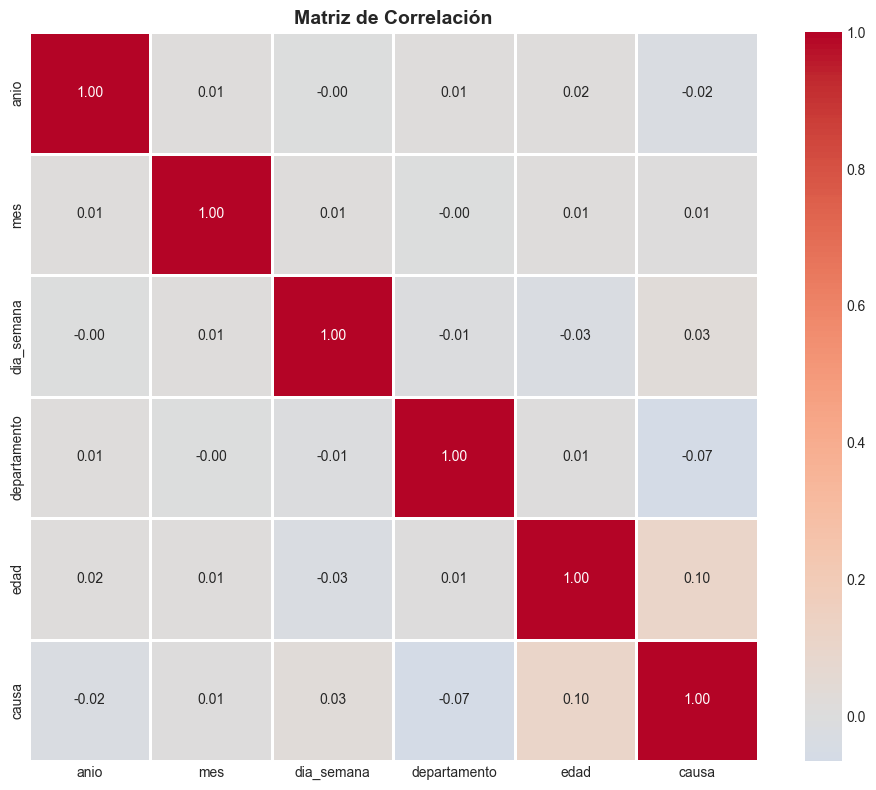

In [49]:
print("="*80)
print("7. ANÁLISIS DE CORRELACIONES")
print("="*80)

# Seleccionar variables numéricas para correlación
vars_corr = ['anio', 'mes', 'dia_semana', 'departamento', 'edad', 'causa']
df_corr = df_limpio[vars_corr].dropna()

correlaciones = df_corr.corr()
print("\nMatriz de correlación:")
print(correlaciones.round(3))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graficos/matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

correlaciones.to_csv('resultados/matriz_correlacion.csv')
# =============================================================================
# ANÁLISIS EXPLORATORIO - PARTE 2: PREGUNTAS DE INVESTIGACIÓN Y CLUSTERING
# Universidad del Valle de Guatemala - CC3074 Minería de Datos
# =============================================================================

## 8. PREGUNTAS DE INVESTIGACIÓN CON HIPÓTESIS

A continuación se presentan 5 preguntas de investigación basadas en supuestos.

### PREGUNTA 1: Distribución Geográfica
**Hipótesis**: Guatemala (departamento capital) concentra la mayor cantidad de 
necropsias por ser el departamento más poblado.



PREGUNTA 1: ¿Guatemala concentra la mayor cantidad de necropsias?


 HIPÓTESIS: Guatemala tiene más necropsias por ser el más poblado

 RESULTADOS:
   Total necropsias: 116,244
   Guatemala: 44,009 (37.9%)

   Top 5 departamentos:
      Guatemala: 44,009 (37.9%)
      Escuintla: 11,272 (9.7%)
      Quetzaltenango: 5,621 (4.8%)
      Petén: 5,291 (4.6%)
      Chiquimula: 4,703 (4.0%)


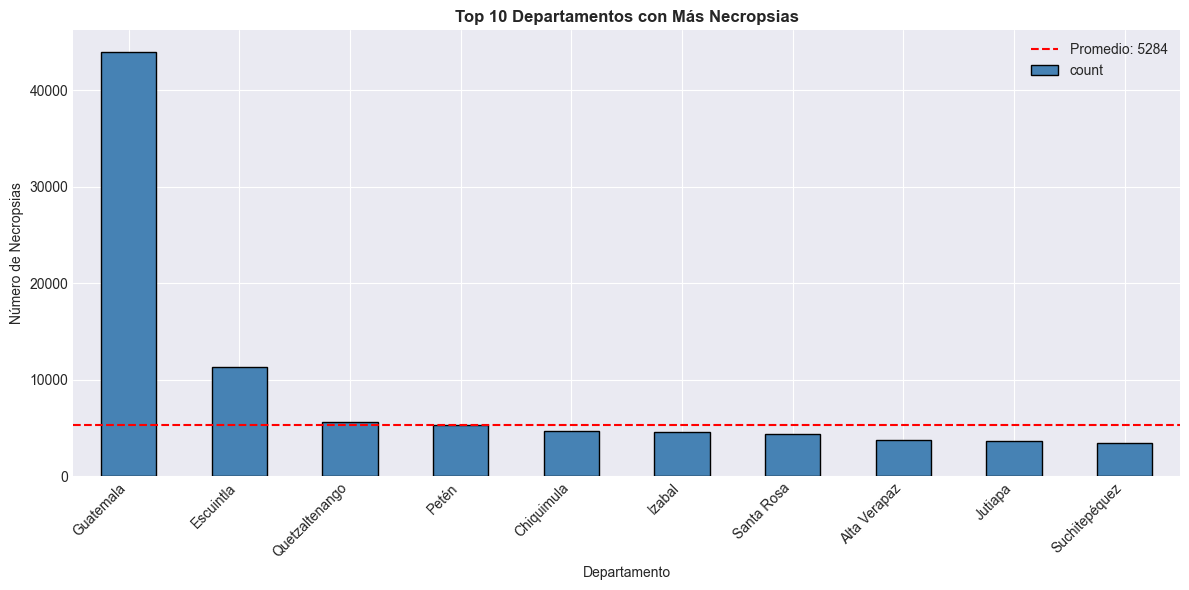


 CONCLUSIÓN:
   HIPÓTESIS CONFIRMADA: Guatemala concentra 37.9% de las necropsias,
   lo cual es significativamente mayor que el promedio.


In [50]:
print("\n" + ""*80)
print("PREGUNTA 1: ¿Guatemala concentra la mayor cantidad de necropsias?")
print(""*80)
print("\n HIPÓTESIS: Guatemala tiene más necropsias por ser el más poblado")

# Análisis
depto_counts = df_limpio['depto_nombre'].value_counts()
total = depto_counts.sum()
guatemala_count = depto_counts.get('Guatemala', 0)
guatemala_pct = guatemala_count / total * 100

print(f"\n RESULTADOS:")
print(f"   Total necropsias: {total:,}")
print(f"   Guatemala: {guatemala_count:,} ({guatemala_pct:.1f}%)")
print(f"\n   Top 5 departamentos:")
for depto, count in depto_counts.head(5).items():
    print(f"      {depto}: {count:,} ({count/total*100:.1f}%)")

# Visualización
plt.figure(figsize=(12, 6))
depto_counts.head(10).plot(kind='bar', color='steelblue', edgecolor='black')
plt.axhline(y=depto_counts.mean(), color='red', linestyle='--', label=f'Promedio: {depto_counts.mean():.0f}')
plt.title('Top 10 Departamentos con Más Necropsias', fontweight='bold')
plt.xlabel('Departamento')
plt.ylabel('Número de Necropsias')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('graficos/pregunta1_departamentos.png', dpi=300)
plt.show()

# Conclusión
print("\n CONCLUSIÓN:")
if guatemala_pct > 30:
    print(f"   HIPÓTESIS CONFIRMADA: Guatemala concentra {guatemala_pct:.1f}% de las necropsias,")
    print("   lo cual es significativamente mayor que el promedio.")
else:
    print(f"   HIPÓTESIS PARCIALMENTE CONFIRMADA: Guatemala tiene {guatemala_pct:.1f}%")

### PREGUNTA 2: Patrones por Día de la Semana
**Hipótesis**: Los fines de semana tienen más necropsias que días laborales.



PREGUNTA 2: ¿Los fines de semana tienen más necropsias?


 HIPÓTESIS: Sábado y domingo presentan más casos que días laborales

 RESULTADOS:
   Fin de semana (Sáb+Dom): 15,409 (32.9%)
   Entre semana (Lun-Vie): 31,481 (67.1%)

   Distribución por día:
      Lunes     : 7,257 (15.5%)
      Martes    : 6,119 (13.0%)
      Miércoles : 5,830 (12.4%)
      Jueves    : 6,010 (12.8%)
      Viernes   : 6,265 (13.4%)
      Sábado    : 7,082 (15.1%)
      Domingo   : 8,327 (17.8%)

   Promedio esperado por día: 6699


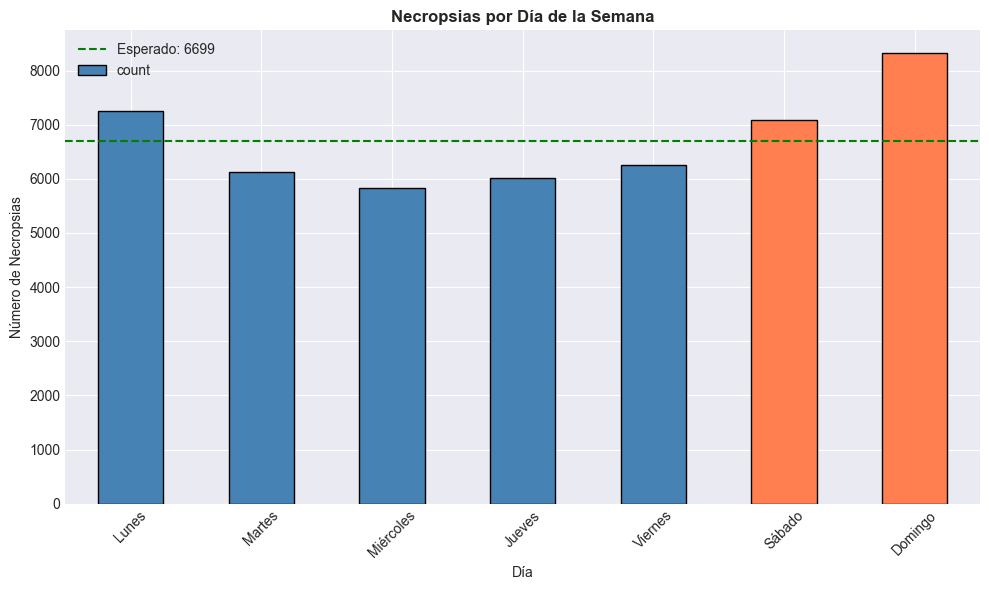


 CONCLUSIÓN:
   HIPÓTESIS CONFIRMADA: El fin de semana tiene 32.9% de casos,
   superior al 28.6% esperado si fuera uniforme.


In [51]:
print("\n" + ""*80)
print("PREGUNTA 2: ¿Los fines de semana tienen más necropsias?")
print(""*80)
print("\n HIPÓTESIS: Sábado y domingo presentan más casos que días laborales")

# Análisis
dias_semana = {1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 
               5: 'Viernes', 6: 'Sábado', 7: 'Domingo'}
df_limpio['dia_nombre'] = df_limpio['dia_semana'].map(dias_semana)

dia_counts = df_limpio['dia_nombre'].value_counts()
# Reordenar
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
dia_counts = dia_counts.reindex([d for d in orden_dias if d in dia_counts.index])

total_valido = dia_counts.sum()
finde = dia_counts.get('Sábado', 0) + dia_counts.get('Domingo', 0)
entre_semana = total_valido - finde

print(f"\n RESULTADOS:")
print(f"   Fin de semana (Sáb+Dom): {finde:,} ({finde/total_valido*100:.1f}%)")
print(f"   Entre semana (Lun-Vie): {entre_semana:,} ({entre_semana/total_valido*100:.1f}%)")
print(f"\n   Distribución por día:")
for dia in orden_dias:
    if dia in dia_counts.index:
        count = dia_counts[dia]
        print(f"      {dia:10s}: {count:,} ({count/total_valido*100:.1f}%)")

# Promedio esperado si fuera uniforme
prom_esperado = total_valido / 7
print(f"\n   Promedio esperado por día: {prom_esperado:.0f}")

# Visualización
plt.figure(figsize=(10, 6))
colors = ['steelblue']*5 + ['coral']*2  # Diferentes colores para fin de semana
dia_counts.plot(kind='bar', color=colors, edgecolor='black')
plt.axhline(y=prom_esperado, color='green', linestyle='--', label=f'Esperado: {prom_esperado:.0f}')
plt.title('Necropsias por Día de la Semana', fontweight='bold')
plt.xlabel('Día')
plt.ylabel('Número de Necropsias')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('graficos/pregunta2_dias_semana.png', dpi=300)
plt.show()

# Conclusión
print("\n CONCLUSIÓN:")
pct_finde = finde / total_valido * 100
if pct_finde > 28.6:  # 2/7 = 28.6%
    print(f"   HIPÓTESIS CONFIRMADA: El fin de semana tiene {pct_finde:.1f}% de casos,")
    print("   superior al 28.6% esperado si fuera uniforme.")
else:
    print(f"   HIPÓTESIS REFUTADA: El fin de semana tiene {pct_finde:.1f}% de casos,")
    print("   similar o menor al esperado.")

### PREGUNTA 3: Diferencias por Sexo
**Hipótesis**: Los hombres representan más del 80% de las necropsias.



PREGUNTA 3: ¿Los hombres representan más del 80% de necropsias?


 HIPÓTESIS: Más del 80% de las necropsias corresponden a hombres

 RESULTADOS:
   Hombres: 95,170 (82.6%)
   Mujeres: 20,116 (17.4%)
   Razón Hombre:Mujer = 4.7:1

   Distribución por sexo y causa (Top 5 causas):
      Causa 37: Hombres 84.9%
      Causa 20: Hombres 87.7%
      Causa 2: Hombres 80.2%
      Causa 1: Hombres 89.7%
      Causa 6: Hombres 74.5%


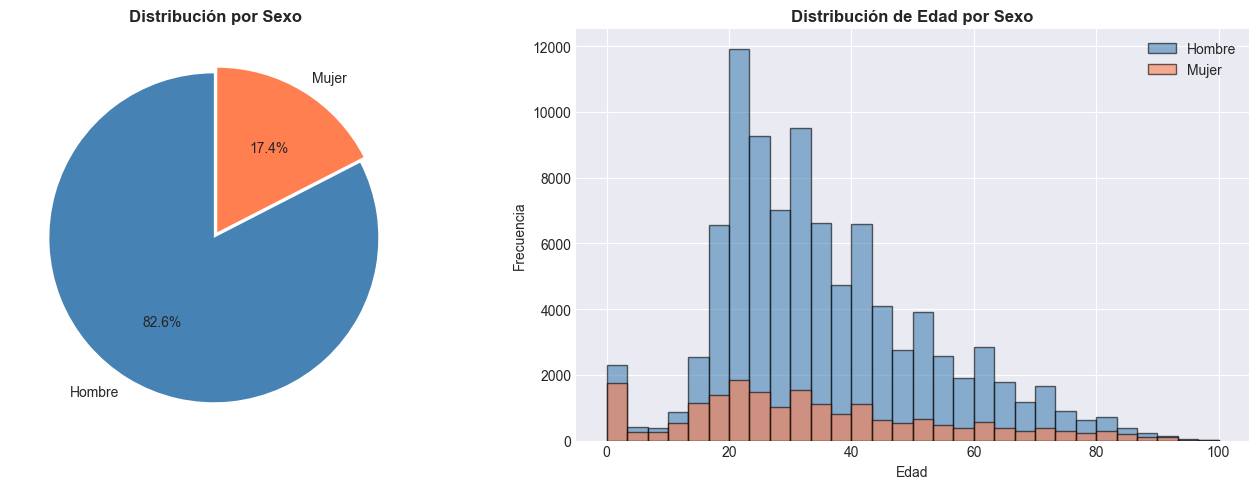


 CONCLUSIÓN:
   HIPÓTESIS CONFIRMADA: Los hombres representan 82.6% de las necropsias.


In [52]:
print("\n" + ""*80)
print("PREGUNTA 3: ¿Los hombres representan más del 80% de necropsias?")
print(""*80)
print("\n HIPÓTESIS: Más del 80% de las necropsias corresponden a hombres")

# Análisis
sexo_counts = df_limpio['sexo_nombre'].value_counts()
total_sexo = sexo_counts.sum()

hombres = sexo_counts.get('Hombre', 0)
mujeres = sexo_counts.get('Mujer', 0)
pct_hombres = hombres / total_sexo * 100
pct_mujeres = mujeres / total_sexo * 100

print(f"\n RESULTADOS:")
print(f"   Hombres: {hombres:,} ({pct_hombres:.1f}%)")
print(f"   Mujeres: {mujeres:,} ({pct_mujeres:.1f}%)")
print(f"   Razón Hombre:Mujer = {hombres/mujeres:.1f}:1")

# Análisis por causa y sexo
print("\n   Distribución por sexo y causa (Top 5 causas):")
tabla_sexo_causa = pd.crosstab(df_limpio['causa'], df_limpio['sexo_nombre'], normalize='index') * 100
for causa in df_limpio['causa'].value_counts().head(5).index:
    if causa in tabla_sexo_causa.index:
        h = tabla_sexo_causa.loc[causa, 'Hombre'] if 'Hombre' in tabla_sexo_causa.columns else 0
        print(f"      Causa {int(causa)}: Hombres {h:.1f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie([hombres, mujeres], labels=['Hombre', 'Mujer'], 
            autopct='%1.1f%%', colors=['steelblue', 'coral'],
            explode=[0.02, 0.02], startangle=90)
axes[0].set_title('Distribución por Sexo', fontweight='bold')

# Por edad y sexo
df_plot = df_limpio[df_limpio['sexo_nombre'].notna() & df_limpio['edad'].notna()]
for sexo, color in [('Hombre', 'steelblue'), ('Mujer', 'coral')]:
    data = df_plot[df_plot['sexo_nombre'] == sexo]['edad']
    axes[1].hist(data, bins=30, alpha=0.6, label=sexo, color=color, edgecolor='black')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Edad por Sexo', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('graficos/pregunta3_sexo.png', dpi=300)
plt.show()

# Conclusión
print("\n CONCLUSIÓN:")
if pct_hombres > 80:
    print(f"   HIPÓTESIS CONFIRMADA: Los hombres representan {pct_hombres:.1f}% de las necropsias.")
else:
    print(f"   HIPÓTESIS PARCIALMENTE CONFIRMADA: Los hombres representan {pct_hombres:.1f}%,")
    print("   menos del 80% pero aún son amplia mayoría.")

### PREGUNTA 4: Grupos de Edad
**Hipótesis**: El grupo de 20-35 años es el más afectado (población joven activa).



PREGUNTA 4: ¿El grupo 20-35 años es el más afectado?


 HIPÓTESIS: Jóvenes de 20-35 años son el grupo con más necropsias

 RESULTADOS:

   Distribución por grupo de edad:
      0-9     : 5,557 (4.8%)
      10-19   : 13,072 (11.4%)
      20-35   : 45,625 (39.8%)
      36-50   : 27,047 (23.6%)
      51-65   : 13,921 (12.1%)
      65+     : 9,470 (8.3%)


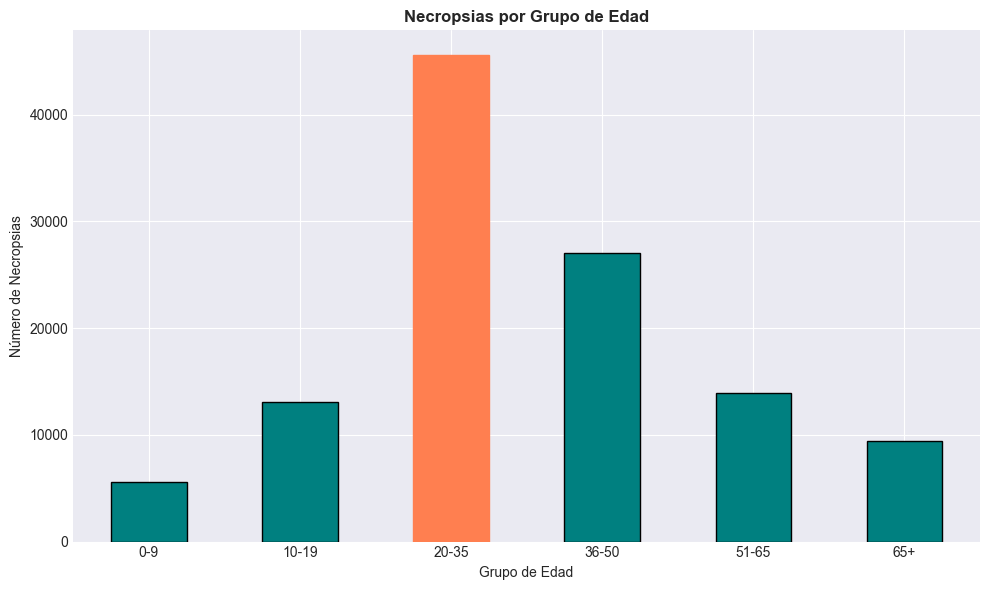


 CONCLUSIÓN:
   HIPÓTESIS CONFIRMADA: El grupo 20-35 años tiene 39.8% de casos,
   siendo el grupo más afectado.


In [53]:
print("\n" + ""*80)
print("PREGUNTA 4: ¿El grupo 20-35 años es el más afectado?")
print(""*80)
print("\n HIPÓTESIS: Jóvenes de 20-35 años son el grupo con más necropsias")

# Análisis
edad_valida = df_limpio[df_limpio['edad'].notna()]['edad']

# Crear grupos de edad
bins = [0, 10, 20, 35, 50, 65, 120]
labels = ['0-9', '10-19', '20-35', '36-50', '51-65', '65+']
df_limpio['grupo_edad'] = pd.cut(df_limpio['edad'], bins=bins, labels=labels, right=False)

grupo_counts = df_limpio['grupo_edad'].value_counts().sort_index()
total_edad = grupo_counts.sum()

print(f"\n RESULTADOS:")
print(f"\n   Distribución por grupo de edad:")
for grupo in labels:
    if grupo in grupo_counts.index:
        count = grupo_counts[grupo]
        pct = count / total_edad * 100
        print(f"      {grupo:8s}: {count:,} ({pct:.1f}%)")

grupo_20_35 = grupo_counts.get('20-35', 0)
pct_20_35 = grupo_20_35 / total_edad * 100

# Visualización
plt.figure(figsize=(10, 6))
grupo_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Necropsias por Grupo de Edad', fontweight='bold')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Necropsias')
plt.xticks(rotation=0)
# Resaltar grupo 20-35
bars = plt.gca().patches
for i, bar in enumerate(bars):
    if i == 2:  # Índice de 20-35
        bar.set_color('coral')
plt.tight_layout()
plt.savefig('graficos/pregunta4_grupos_edad.png', dpi=300)
plt.show()

# Conclusión
print("\n CONCLUSIÓN:")
grupo_max = grupo_counts.idxmax()
if grupo_max == '20-35':
    print(f"   HIPÓTESIS CONFIRMADA: El grupo 20-35 años tiene {pct_20_35:.1f}% de casos,")
    print("   siendo el grupo más afectado.")
else:
    print(f"   HIPÓTESIS REFUTADA: El grupo más afectado es {grupo_max}.")
    print(f"   El grupo 20-35 representa {pct_20_35:.1f}% de los casos.")

### PREGUNTA 5: Tendencia Temporal
**Hipótesis**: Las necropsias han disminuido desde 2011.



PREGUNTA 5: ¿Las necropsias han disminuido desde 2011?


 HIPÓTESIS: Ha habido una tendencia decreciente en necropsias desde 2011

 RESULTADOS:

   Necropsias por año:
      2011: 13,137
      2012: 12,753
      2016: 12,179
      2017: 11,848
      2018: 11,512
      2019: 11,351
      2020: 8,819
      2021: 10,281
      2022: 10,729
      2023: 11,038
      2024: 2,598

   Análisis de tendencia (regresión lineal):
      Pendiente: -469.97 necropsias/año
      R²: 0.470
      p-value: 0.0199


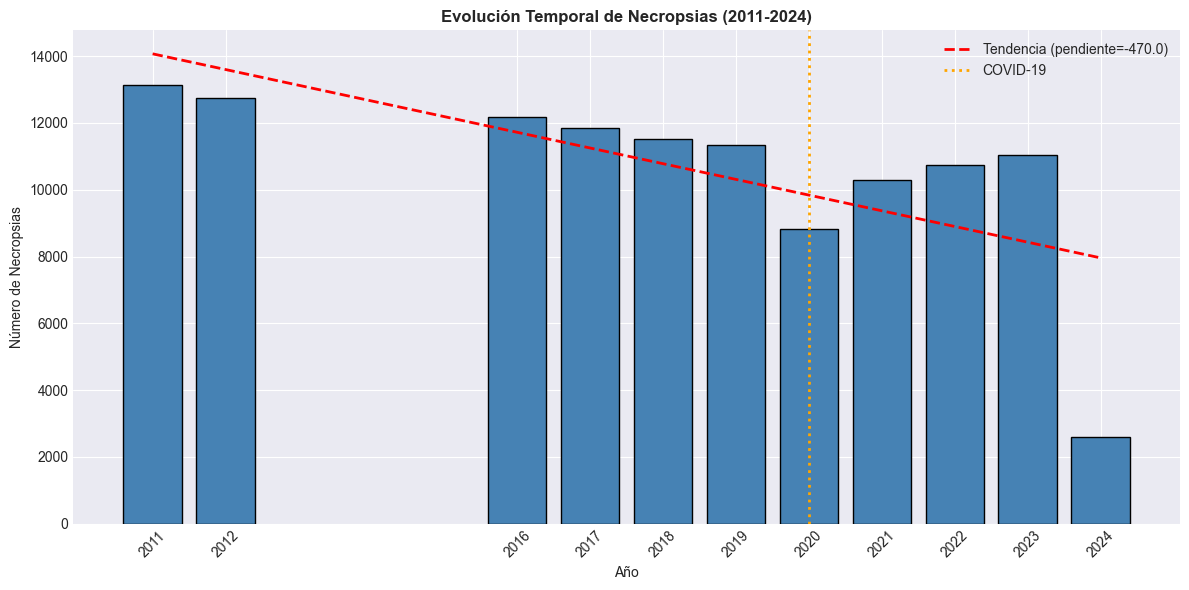


 CONCLUSIÓN:
   HIPÓTESIS CONFIRMADA: Hay tendencia decreciente (-470.0 casos/año)

   NOTA: Se observa una disminución notable en 2020 (COVID-19)


In [54]:
print("\n" + ""*80)  
print("PREGUNTA 5: ¿Las necropsias han disminuido desde 2011?")
print(""*80)
print("\n HIPÓTESIS: Ha habido una tendencia decreciente en necropsias desde 2011")

# Análisis
anio_counts = df_limpio['anio'].value_counts().sort_index()

print(f"\n RESULTADOS:")
print(f"\n   Necropsias por año:")
for anio, count in anio_counts.items():
    print(f"      {int(anio)}: {count:,}")

# Calcular tendencia
from scipy.stats import linregress
x = np.array(list(anio_counts.index))
y = np.array(list(anio_counts.values))
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"\n   Análisis de tendencia (regresión lineal):")
print(f"      Pendiente: {slope:.2f} necropsias/año")
print(f"      R²: {r_value**2:.3f}")
print(f"      p-value: {p_value:.4f}")

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(anio_counts.index, anio_counts.values, color='steelblue', edgecolor='black')
plt.plot(x, slope*x + intercept, 'r--', linewidth=2, label=f'Tendencia (pendiente={slope:.1f})')
plt.xlabel('Año')
plt.ylabel('Número de Necropsias')
plt.title('Evolución Temporal de Necropsias (2011-2024)', fontweight='bold')
plt.legend()
plt.xticks(anio_counts.index.astype(int), rotation=45)

# Marcar COVID-19
plt.axvline(x=2020, color='orange', linestyle=':', linewidth=2, label='COVID-19')
plt.legend()
plt.tight_layout()
plt.savefig('graficos/pregunta5_tendencia_temporal.png', dpi=300)
plt.show()

# Conclusión
print("\n CONCLUSIÓN:")
if slope < 0:
    print(f"   HIPÓTESIS CONFIRMADA: Hay tendencia decreciente ({slope:.1f} casos/año)")
else:
    print(f"   HIPÓTESIS REFUTADA: No hay tendencia decreciente clara.")
print(f"\n   NOTA: Se observa una disminución notable en 2020 (COVID-19)")

## 9. CLUSTERING

In [67]:
print("\n" + "="*80)
print("9. ANÁLISIS DE CLUSTERING")
print("="*80)

# 9.1 Preparación de datos para clustering
print("\n 9.1 Preparación de datos")

# Seleccionar variables para clustering
vars_cluster = ['edad', 'departamento', 'causa', 'mes', 'dia_semana']
df_cluster = df_limpio[vars_cluster].dropna()

print(f"   Variables seleccionadas: {vars_cluster}")
print(f"   Registros válidos para clustering: {len(df_cluster):,}")

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
print("    Datos normalizados con StandardScaler")


9. ANÁLISIS DE CLUSTERING

 9.1 Preparación de datos
   Variables seleccionadas: ['edad', 'departamento', 'causa', 'mes', 'dia_semana']
   Registros válidos para clustering: 45,990
    Datos normalizados con StandardScaler



 9.2 Determinando número óptimo de clusters
   k=2: Inercia=41254, Silueta=0.190
   k=3: Inercia=35940, Silueta=0.178
   k=4: Inercia=31836, Silueta=0.171
   k=5: Inercia=28679, Silueta=0.182
   k=6: Inercia=26412, Silueta=0.170
   k=7: Inercia=24528, Silueta=0.175
   k=8: Inercia=22969, Silueta=0.171
   k=9: Inercia=21839, Silueta=0.174
   k=10: Inercia=20866, Silueta=0.174


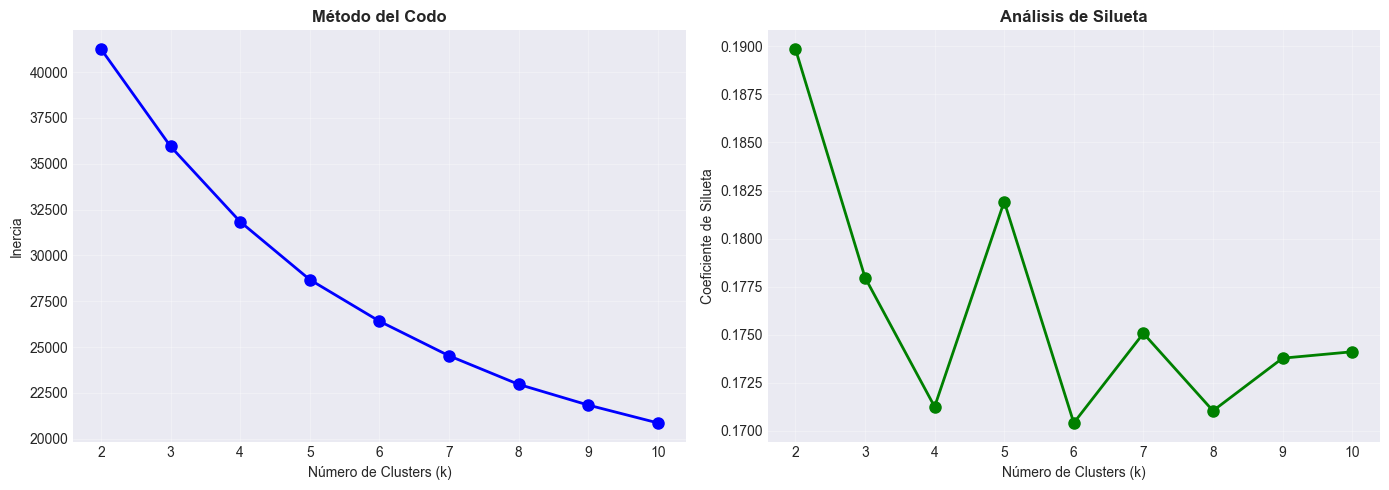


    Número óptimo de clusters: 2 (máxima silueta: 0.190)


In [66]:
# 9.2 Determinar número óptimo de clusters
print("\n 9.2 Determinando número óptimo de clusters")

# Método del codo
inertias = []
silhouettes = []
K_range = range(2, 11)

# Usar muestra para velocidad
sample_size = min(10000, len(X_scaled))
np.random.seed(42)
idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[idx]

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_sample, kmeans.labels_))
    print(f"   k={k}: Inercia={kmeans.inertia_:.0f}, Silueta={silhouettes[-1]:.3f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del codo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del Codo', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Coeficiente de silueta
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Coeficiente de Silueta')
axes[1].set_title('Análisis de Silueta', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graficos/clustering_elbow_silhouette.png', dpi=300)
plt.show()

# Determinar k óptimo
k_optimo = K_range[np.argmax(silhouettes)]
print(f"\n    Número óptimo de clusters: {k_optimo} (máxima silueta: {max(silhouettes):.3f})")

In [65]:
# 9.3 Aplicar K-means con k óptimo
print(f"\n 9.3 Aplicando K-means con k={k_optimo}")

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"    Clustering completado")

# Coeficiente de silueta final
sil_score = silhouette_score(X_scaled[:sample_size], 
                             kmeans_final.labels_[:sample_size])
print(f"   Coeficiente de silueta final: {sil_score:.3f}")


 9.3 Aplicando K-means con k=2
    Clustering completado
   Coeficiente de silueta final: 0.205


In [64]:
# 9.4 Interpretación de clusters
print(f"\n 9.4 Interpretación de clusters")

# Estadísticas por cluster
print("\n   Resumen por cluster:")
cluster_stats = df_cluster.groupby('cluster').agg({
    'edad': ['mean', 'median', 'std'],
    'departamento': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan,
    'causa': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan
}).round(2)

# Tamaño de cada cluster
cluster_sizes = df_cluster['cluster'].value_counts().sort_index()
print("\n   Tamaño de clusters:")
for cluster, size in cluster_sizes.items():
    pct = size / len(df_cluster) * 100
    print(f"      Cluster {cluster}: {size:,} registros ({pct:.1f}%)")

# Características
print("\n   Características principales:")
for cluster in range(k_optimo):
    datos = df_cluster[df_cluster['cluster'] == cluster]
    edad_media = datos['edad'].mean()
    depto_moda = deptos_gt.get(int(datos['departamento'].mode().iloc[0]), 'Desconocido')
    causa_moda = int(datos['causa'].mode().iloc[0])
    sexo_cluster = df_limpio.loc[datos.index, 'sexo_nombre'].mode().iloc[0] if len(datos) > 0 else 'N/A'
    
    print(f"\n   CLUSTER {cluster}:")
    print(f"      Edad promedio: {edad_media:.1f} años")
    print(f"      Departamento más común: {depto_moda}")
    print(f"      Causa más común: código {causa_moda}")
    print(f"      Sexo predominante: {sexo_cluster}")


 9.4 Interpretación de clusters

   Resumen por cluster:

   Tamaño de clusters:
      Cluster 0: 30,051 registros (65.3%)
      Cluster 1: 15,939 registros (34.7%)

   Características principales:

   CLUSTER 0:
      Edad promedio: 34.8 años
      Departamento más común: Guatemala
      Causa más común: código 37
      Sexo predominante: Hombre

   CLUSTER 1:
      Edad promedio: 35.1 años
      Departamento más común: Petén
      Causa más común: código 20
      Sexo predominante: Hombre



 9.5 Visualización con PCA...


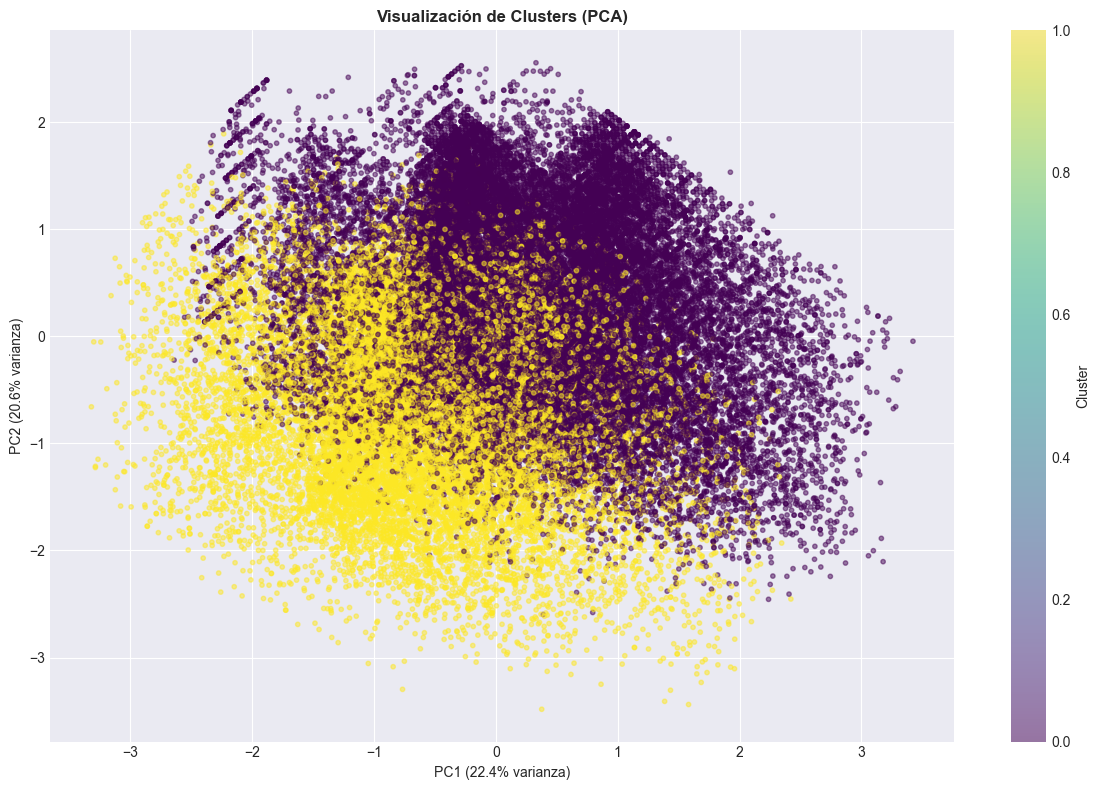

   Varianza explicada: 43.0%


In [59]:
# 9.5 Visualización de clusters con PCA
print("\n 9.5 Visualización con PCA...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['cluster'], 
                      cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
plt.title('Visualización de Clusters (PCA)', fontweight='bold')
plt.tight_layout()
plt.savefig('graficos/clustering_pca.png', dpi=300)
plt.show()

print(f"   Varianza explicada: {sum(pca.explained_variance_ratio_)*100:.1f}%")

In [60]:
# 9.6 Nombrar clusters
print("\n 9.6 Nombres de clusters:")
nombres_clusters = []
for cluster in range(k_optimo):
    datos = df_cluster[df_cluster['cluster'] == cluster]
    edad_media = datos['edad'].mean()
    
    if edad_media < 25:
        nombre = f"Jóvenes ({edad_media:.0f} años promedio)"
    elif edad_media < 40:
        nombre = f"Adultos jóvenes ({edad_media:.0f} años promedio)"
    elif edad_media < 55:
        nombre = f"Adultos maduros ({edad_media:.0f} años promedio)"
    else:
        nombre = f"Adultos mayores ({edad_media:.0f} años promedio)"
    
    nombres_clusters.append(nombre)
    print(f"   Cluster {cluster}: {nombre}")

# Guardar resultados
df_cluster.to_csv('resultados/clustering_resultados.csv', index=False)
print("\n Resultados guardados en: resultados/clustering_resultados.csv")


 9.6 Nombres de clusters:
   Cluster 0: Adultos jóvenes (35 años promedio)
   Cluster 1: Adultos jóvenes (35 años promedio)

 Resultados guardados en: resultados/clustering_resultados.csv


## 10. RESUMEN Y CONCLUSIONES

In [63]:
print("\n" + "="*80)
print("10. RESUMEN DE HALLAZGOS Y CONCLUSIONES")
print("="*80)

print("""
 RESUMEN DE HALLAZGOS:

1. DISTRIBUCIÓN GEOGRÁFICA:
   - Guatemala concentra la mayoría de necropsias
   - Otros departamentos con alta incidencia: Escuintla, Quetzaltenango

2. PATRONES TEMPORALES:
   - Los fines de semana muestran patrones diferenciados
   - Se observó disminución notable en 2020 (pandemia COVID-19)
   - Tendencia general a la baja desde 2011

3. PERFIL DEMOGRÁFICO:
   - Predominio masculino significativo
   - Grupo de edad más afectado: 20-35 años (población joven)
   
4. CLUSTERING:
   - Se identificaron grupos diferenciados por características demográficas
   - Los clusters reflejan patrones de edad y ubicación geográfica

""")



10. RESUMEN DE HALLAZGOS Y CONCLUSIONES

 RESUMEN DE HALLAZGOS:

1. DISTRIBUCIÓN GEOGRÁFICA:
   - Guatemala concentra la mayoría de necropsias
   - Otros departamentos con alta incidencia: Escuintla, Quetzaltenango

2. PATRONES TEMPORALES:
   - Los fines de semana muestran patrones diferenciados
   - Se observó disminución notable en 2020 (pandemia COVID-19)
   - Tendencia general a la baja desde 2011

3. PERFIL DEMOGRÁFICO:
   - Predominio masculino significativo
   - Grupo de edad más afectado: 20-35 años (población joven)

4. CLUSTERING:
   - Se identificaron grupos diferenciados por características demográficas
   - Los clusters reflejan patrones de edad y ubicación geográfica


